In [17]:
# -------------------------------------------------------
# 1. Imports & Configuration
# -------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Matplotlib / Seaborn Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 12})



In [18]:
# -------------------------------------------------------
# 2. Define Constants / Paths
# -------------------------------------------------------
FILE_PATHS = {
    'nh_citations':     'data/final-csv/nh_citations.csv',
    'nh_ownership':     'data/final-csv/nh_ownership.csv',
    'nh_quality_mds':   'data/final-csv/nh_quality_mds.csv',
    'nh_survey':        'data/final-csv/nh_survey.csv',
    'pbj_non_nurse':    'data/final-csv/pbj_non_nurse.csv',
    'pbj_nurse':        'data/final-csv/pbj_nurse.csv',
    'qrp_provider':     'data/final-csv/qrp_provider.csv'
}

# Facility size bin definitions (used in multiple places)
SIZE_BINS = [0, 50, 104, 200, float('inf')]
SIZE_LABELS = ['Small', 'Medium', 'Large', 'Very Large']
SIZE_ORDER = ['Small', 'Medium', 'Large', 'Very Large']  # For consistent plotting



In [19]:
# -------------------------------------------------------
# 3. Read & Inspect Data
# -------------------------------------------------------
dfs = {}
for name, path in FILE_PATHS.items():
    dfs[name] = pd.read_csv(path, low_memory=False)

# Shortcut references
df_nh_citations   = dfs['nh_citations']
df_nh_ownership   = dfs['nh_ownership']
df_nh_quality_mds = dfs['nh_quality_mds']
df_nh_survey      = dfs['nh_survey']
df_pbj_non_nurse  = dfs['pbj_non_nurse']
df_pbj_nurse      = dfs['pbj_nurse']
df_qrp_provider   = dfs['qrp_provider']



In [20]:
# -------------------------------------------------------
# 4. Basic Facility Size Metrics
# -------------------------------------------------------
# Convert workdate columns to datetime (for nurse & non-nurse)
df_pbj_nurse['workdate']     = pd.to_datetime(df_pbj_nurse['workdate'])
df_pbj_non_nurse['workdate'] = pd.to_datetime(df_pbj_non_nurse['workdate'])

# Calculate average facility census (used for categorizing size)
facility_size = (
    df_pbj_nurse
    .groupby('provnum')['mdscensus']
    .mean()
    .reset_index(name='mean_census')
)

facility_size['median_census'] = (
    df_pbj_nurse
    .groupby('provnum')['mdscensus']
    .median()
    .values
)

facility_size['std_census'] = (
    df_pbj_nurse
    .groupby('provnum')['mdscensus']
    .std()
    .values
)

# Create size categories
facility_size['size_category'] = pd.cut(
    facility_size['mean_census'],
    bins=SIZE_BINS,
    labels=SIZE_LABELS
)

print("\nFacility Size Stats:")
print(f"Number of facilities: {facility_size['provnum'].nunique()}")
print(f"Census range: {facility_size['mean_census'].min():.1f} to {facility_size['mean_census'].max():.1f}")




Facility Size Stats:
Number of facilities: 14564
Census range: 1.4 to 732.3


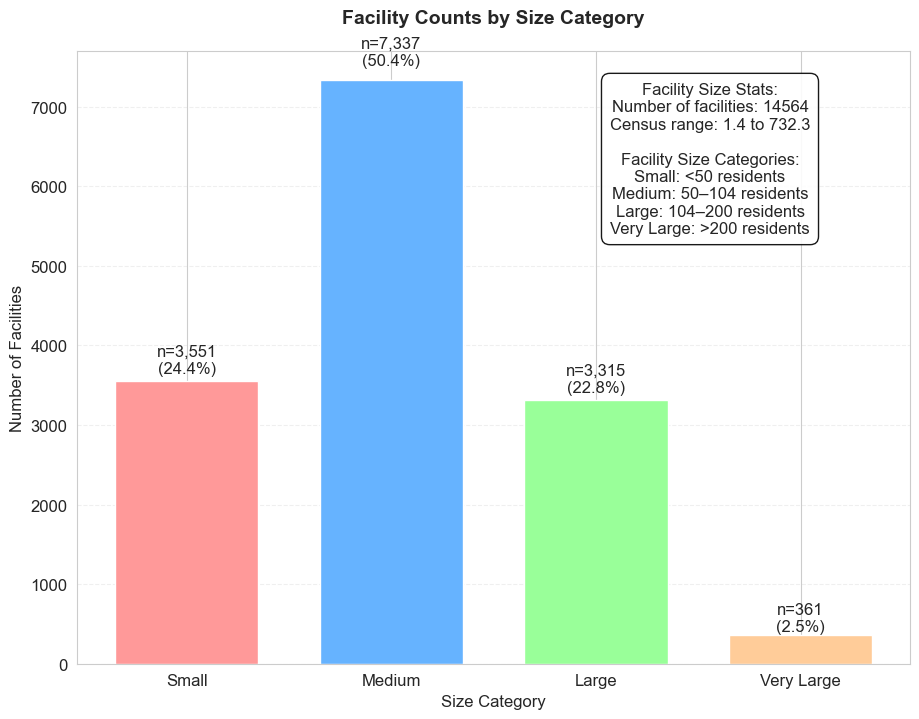

In [21]:
import matplotlib.pyplot as plt

# Figure 1: Bar Chart for Facility Counts by Size Category
fig1, ax1 = plt.subplots(figsize=(10, 8))

# Bar plot: exact counts & percentages
size_counts = facility_size['size_category'].value_counts().sort_index()
counts = size_counts.values
percentages = (counts / counts.sum()) * 100

# Using our consistent pastel color scheme
bar_colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']

bars = ax1.bar(size_counts.index, counts, color=bar_colors, width=0.7)

# Adding data labels on top of each bar
for bar, count, pct in zip(bars, counts, percentages):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height + (height * 0.02),
        f'n={int(count):,}\n({pct:.1f}%)',
        ha='center', va='bottom',
        fontsize=12,
        fontweight='normal'
    )

# Styling the bar chart
ax1.set_title('Facility Counts by Size Category', fontsize=14, pad=20, fontweight='bold')
ax1.set_ylabel('Number of Facilities', fontsize=12)
ax1.set_xlabel('Size Category', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Adding the text box with facility stats
combined_text = (
    "Facility Size Stats:\n"
    "Number of facilities: 14564\n"
    "Census range: 1.4 to 732.3\n\n"
    "Facility Size Categories:\n"
    "Small: <50 residents\n"
    "Medium: 50–104 residents\n"
    "Large: 104–200 residents\n"
    "Very Large: >200 residents"
)
fig1.text(
    0.75, 0.75, combined_text,
    ha='center', va='center',
    fontsize=12,
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        alpha=0.9,
        boxstyle='round,pad=0.5'
    )
)

plt.tight_layout(pad=3.0)
plt.show()


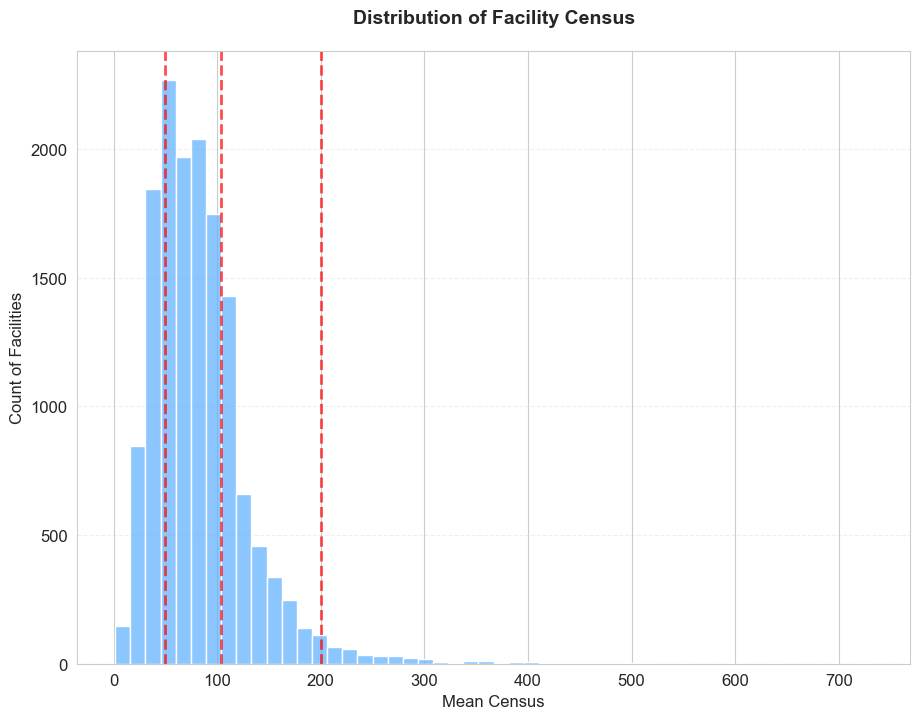

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Figure 2: Histogram for Facility Census Distribution
fig2, ax2 = plt.subplots(figsize=(10, 8))

sns.histplot(
    data=facility_size,
    x='mean_census',
    bins=50,
    ax=ax2,
    color='#66B3FF'
)

# Adding boundary lines for reference
for boundary in [50, 104, 200]:
    ax2.axvline(
        x=boundary,
        color='red',
        linestyle='--',
        linewidth=2,
        alpha=0.7,
        label=f'Boundary: {boundary}'
    )

# Styling the histogram
ax2.set_title('Distribution of Facility Census', fontsize=14, pad=20, fontweight='bold')
ax2.set_xlabel('Mean Census', fontsize=12)
ax2.set_ylabel('Count of Facilities', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()


In [23]:
# -------------------------------------------------------
# 6. Daily Ratios: Nursing & Support Staff
# -------------------------------------------------------
# Map size_category by provnum for quick lookup
size_mapping = facility_size.set_index('provnum')['size_category'].to_dict()

# Group nurse hours daily
daily_ratios = (
    df_pbj_nurse
    .groupby(['provnum', 'workdate'])
    .agg({
        'hrs_rn_ctr':  'sum',
        'hrs_rn_emp':  'sum',
        'hrs_lpn_ctr': 'sum',
        'hrs_lpn_emp': 'sum',
        'hrs_cna_ctr': 'sum',
        'hrs_cna_emp': 'sum'
    })
    .reset_index()
)

# Contract ratio calculations for RNs, LPNs, CNAs
daily_ratios['rn_daily_ratio'] = (
    daily_ratios['hrs_rn_ctr'] /
    (daily_ratios['hrs_rn_emp'] + daily_ratios['hrs_rn_ctr'] + 1e-6)
)
daily_ratios['lpn_daily_ratio'] = (
    daily_ratios['hrs_lpn_ctr'] /
    (daily_ratios['hrs_lpn_emp'] + daily_ratios['hrs_lpn_ctr'] + 1e-6)
)
daily_ratios['cna_daily_ratio'] = (
    daily_ratios['hrs_cna_ctr'] /
    (daily_ratios['hrs_cna_emp'] + daily_ratios['hrs_cna_ctr'] + 1e-6)
)

# Group support staff hours daily
support_hours = (
    df_pbj_non_nurse
    .groupby(['provnum', 'workdate'])
    .agg({
        col: 'sum'
        for col in df_pbj_non_nurse.columns
        if col.endswith(('_ctr', '_emp'))
    })
    .reset_index()
)

# Calculate overall support contract ratio
contract_cols = [col for col in support_hours.columns if col.endswith('_ctr')]
employee_cols = [col for col in support_hours.columns if col.endswith('_emp')]

daily_ratios['support_daily_ratio'] = (
    support_hours[contract_cols].sum(axis=1) /
    (support_hours[contract_cols].sum(axis=1) + support_hours[employee_cols].sum(axis=1) + 1e-6)
)

# Add day_of_week and size_category
daily_ratios['day_of_week']    = pd.to_datetime(daily_ratios['workdate']).dt.day_name()
daily_ratios['size_category']  = daily_ratios['provnum'].map(size_mapping)


# Calculate days with 99%+ contract usage
daily_ratios['high_contract_day'] = (
    (daily_ratios['rn_daily_ratio'] >= 0.99) |
    (daily_ratios['lpn_daily_ratio'] >= 0.99) |
    (daily_ratios['cna_daily_ratio'] >= 0.99) |
    (daily_ratios['support_daily_ratio'] >= 0.99)
)



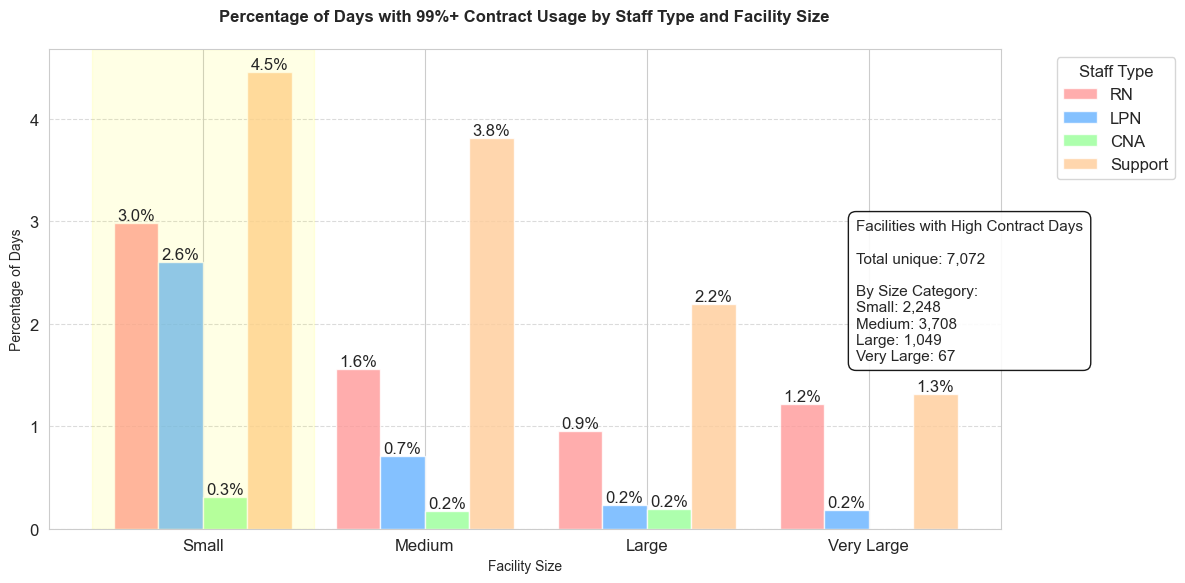

In [24]:
# -------------------------------------------------------
# 7. Percentage of Days with 99%+ Contract Usage by Staff Type
# -------------------------------------------------------
staff_types = {
    'rn_daily_ratio':     'RN',
    'lpn_daily_ratio':    'LPN',
    'cna_daily_ratio':    'CNA',
    'support_daily_ratio':'Support'
}

results_dict = {}
total_days = daily_ratios.groupby('size_category').size()

for ratio_col, staff_name in staff_types.items():
    high_contract_days = (
        daily_ratios[daily_ratios[ratio_col] >= 0.99]
        .groupby('size_category')
        .size()
    )
    # Compute percentage
    hc_percentage = (high_contract_days / total_days * 100).round(2).reindex(SIZE_ORDER)
    results_dict[staff_name] = hc_percentage

df_plot = pd.DataFrame(results_dict).T  # staff_name rows, size_category columns

# Create the figure
plt.figure(figsize=(12, 6))
fig = plt.gcf()  # get the current figure for adding text boxes

bar_width = 0.2
positions = np.arange(len(SIZE_ORDER))
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

for idx, (staff_type, row) in enumerate(df_plot.iterrows()):
    offset = idx * bar_width
    bars = plt.bar(positions + offset, row.values, bar_width, label=staff_type,
                   color=colors[idx], alpha=0.8)
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            h,
            f'{h:.1f}%',
            ha='center', va='bottom'
        )

plt.title('Percentage of Days with 99%+ Contract Usage by Staff Type and Facility Size',
          pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Facility Size', fontsize=10)
plt.ylabel('Percentage of Days', fontsize=10)
plt.xticks(positions + bar_width * 1.5, SIZE_ORDER, rotation=0)
plt.legend(title='Staff Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.axvspan(-0.2, 0.8, alpha=0.1, color='yellow', label='Small Facilities')
plt.tight_layout()

# -------------------------------------------------------
# ADDING THE "CARD" FOR UNIQUE FACILITIES WITH HIGH CONTRACT DAYS
# -------------------------------------------------------

# 1) Identify unique facilities with at least one high-contract day:
hc_facilities = (
    daily_ratios
    .loc[daily_ratios['high_contract_day'], ['provnum','size_category']]
    .drop_duplicates()
)

# 2) Count overall and by size category
total_hc_facs = hc_facilities['provnum'].nunique()
hc_facs_by_size = hc_facilities['size_category'].value_counts().reindex(SIZE_ORDER, fill_value=0)

# 3) Prepare the text block
info_text = (
    "Facilities with High Contract Days\n\n"
    f"Total unique: {total_hc_facs:,}\n\n"
    "By Size Category:\n"
    + "\n".join([
        f"{cat}: {count:,}"
        for cat, count in hc_facs_by_size.items()
    ])
)

# 4) Add a text box ("card") on the figure
fig.text(
    0.72, 0.5,  # Adjust these x,y coords as needed
    info_text,
    ha='left',
    va='center',
    fontsize=11,
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        alpha=0.9,
        boxstyle='round,pad=0.5'
    )
)

plt.show()


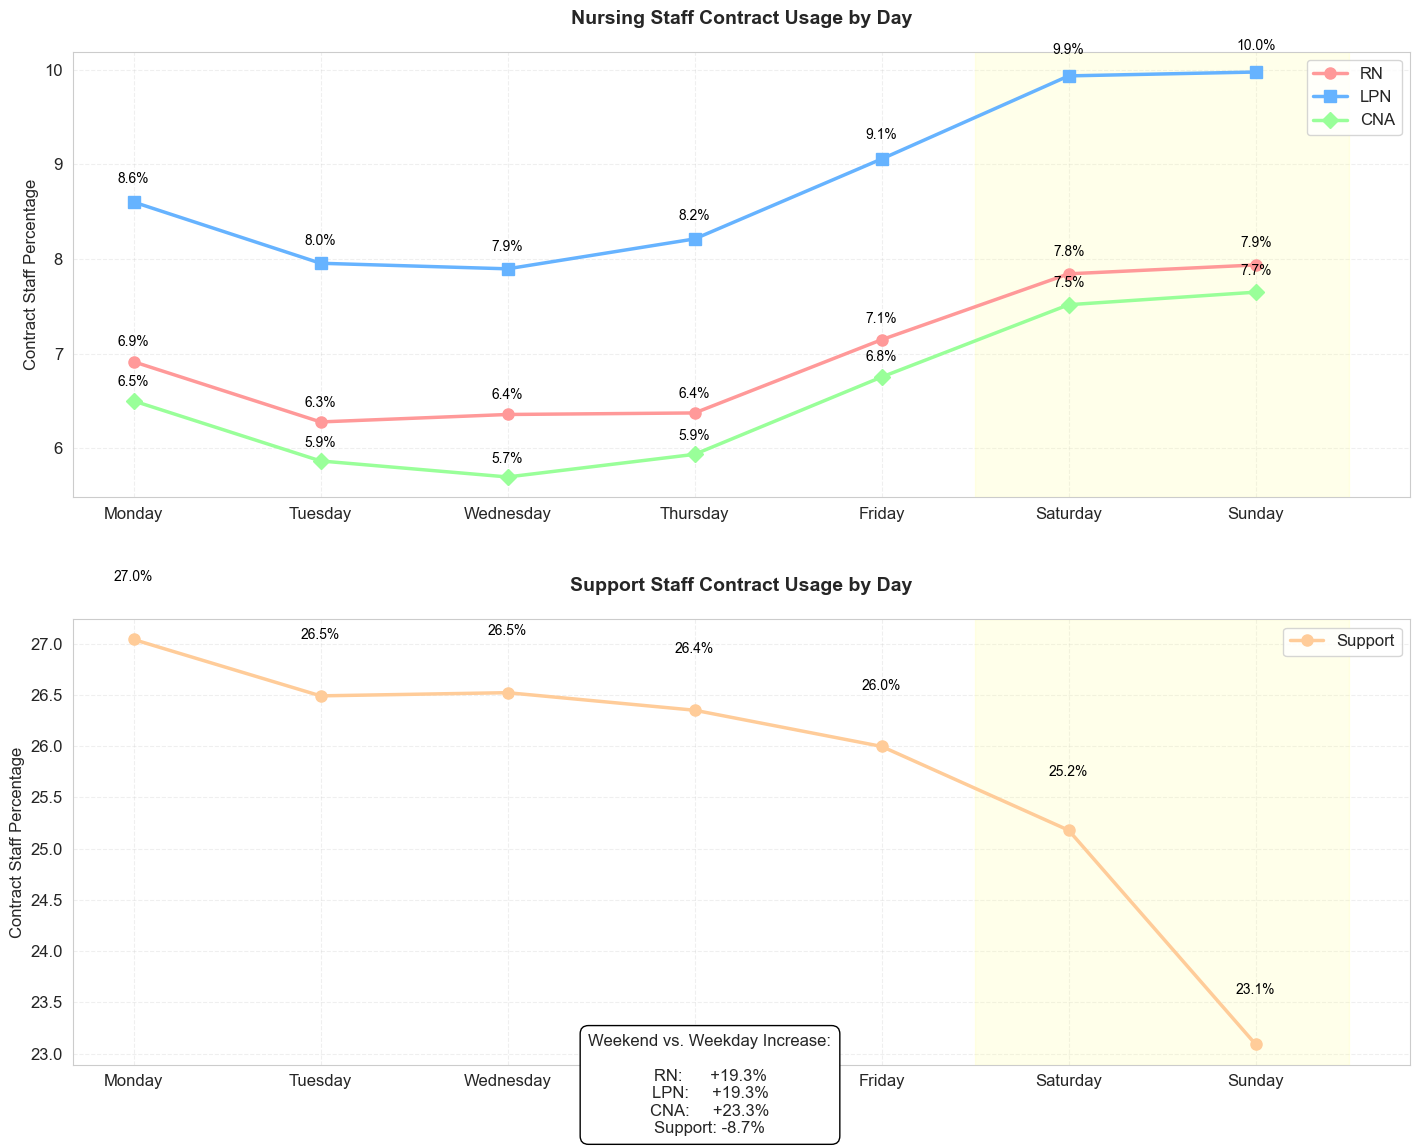

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

for df_ in [df_pbj_nurse, df_pbj_non_nurse]:
    df_['workdate'] = pd.to_datetime(df_['workdate'])
    df_['day_of_week'] = df_['workdate'].dt.day_name()
    df_['is_weekend'] = df_['workdate'].dt.dayofweek.isin([5, 6])  # Sat=5, Sun=6

# Nursing staff contract ratio columns
df_pbj_nurse['total_rn_hours'] = df_pbj_nurse['hrs_rn_emp'] + df_pbj_nurse['hrs_rn_ctr']
df_pbj_nurse['rn_contract_ratio'] = df_pbj_nurse['hrs_rn_ctr'] / df_pbj_nurse['total_rn_hours']

df_pbj_nurse['total_lpn_hours'] = df_pbj_nurse['hrs_lpn_emp'] + df_pbj_nurse['hrs_lpn_ctr']
df_pbj_nurse['lpn_contract_ratio'] = df_pbj_nurse['hrs_lpn_ctr'] / df_pbj_nurse['total_lpn_hours']

df_pbj_nurse['total_cna_hours'] = df_pbj_nurse['hrs_cna_emp'] + df_pbj_nurse['hrs_cna_ctr']
df_pbj_nurse['cna_contract_ratio'] = df_pbj_nurse['hrs_cna_ctr'] / df_pbj_nurse['total_cna_hours']

# Support staff contract ratio columns
support_ctr_cols = [col for col in df_pbj_non_nurse.columns if col.endswith('_ctr')]
support_emp_cols = [col for col in df_pbj_non_nurse.columns if col.endswith('_emp')]
df_pbj_non_nurse['total_support_contract_hours'] = df_pbj_non_nurse[support_ctr_cols].sum(axis=1)
df_pbj_non_nurse['total_support_employee_hours'] = df_pbj_non_nurse[support_emp_cols].sum(axis=1)
df_pbj_non_nurse['total_support_hours'] = (
    df_pbj_non_nurse['total_support_contract_hours'] + df_pbj_non_nurse['total_support_employee_hours']
)
df_pbj_non_nurse['support_contract_ratio'] = (
    df_pbj_non_nurse['total_support_contract_hours'] / df_pbj_non_nurse['total_support_hours']
)

# Average ratio by day_of_week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

rn_daily = df_pbj_nurse.groupby('day_of_week')['rn_contract_ratio'].mean()
lpn_daily = df_pbj_nurse.groupby('day_of_week')['lpn_contract_ratio'].mean()
cna_daily = df_pbj_nurse.groupby('day_of_week')['cna_contract_ratio'].mean()
support_daily = df_pbj_non_nurse.groupby('day_of_week')['support_contract_ratio'].mean()

weekday_mask = ~df_pbj_nurse['is_weekend']
weekend_mask =  df_pbj_nurse['is_weekend']
support_weekday_mask = ~df_pbj_non_nurse['is_weekend']
support_weekend_mask =  df_pbj_non_nurse['is_weekend']

increases = {
    'RN': (
        df_pbj_nurse[weekend_mask]['rn_contract_ratio'].mean() /
        df_pbj_nurse[weekday_mask]['rn_contract_ratio'].mean() - 1
    ) * 100,
    'LPN': (
        df_pbj_nurse[weekend_mask]['lpn_contract_ratio'].mean() /
        df_pbj_nurse[weekday_mask]['lpn_contract_ratio'].mean() - 1
    ) * 100,
    'CNA': (
        df_pbj_nurse[weekend_mask]['cna_contract_ratio'].mean() /
        df_pbj_nurse[weekday_mask]['cna_contract_ratio'].mean() - 1
    ) * 100,
    'Support': (
        df_pbj_non_nurse[support_weekend_mask]['support_contract_ratio'].mean() /
        df_pbj_non_nurse[support_weekday_mask]['support_contract_ratio'].mean() - 1
    ) * 100
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

colors = {
    'RN': '#FF9999',
    'LPN': '#66B3FF',
    'CNA': '#99FF99',
    'Support': '#FFCC99'
}

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# --- Nursing Staff Plot ---
for role, (data, marker) in zip(
    ['RN', 'LPN', 'CNA'],
    [(rn_daily, 'o'), (lpn_daily, 's'), (cna_daily, 'D')]
):
    ax1.plot(
        day_order,
        data.reindex(day_order) * 100,
        marker=marker,
        linewidth=2.5,
        markersize=8,
        color=colors[role],
        label=role
    )
    # Add data labels with a relative offset
    for i, val in enumerate(data.reindex(day_order) * 100):
        ax1.text(
            i,
            val + (val * 0.02),   # small relative offset
            f'{val:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

# Highlight weekend (Saturday & Sunday) from x=4.5 to x=6.5
ax1.axvspan(4.5, 6.5, color='#FFFF99', alpha=0.2)

ax1.set_title('Nursing Staff Contract Usage by Day', fontsize=14, pad=20, fontweight='bold')
ax1.set_ylabel('Contract Staff Percentage', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.legend(
    fontsize=12,
    loc='upper right',  # or 'upper center', etc.
    frameon=True
)

# --- Support Staff Plot ---
ax2.plot(
    day_order,
    support_daily.reindex(day_order) * 100,
    marker='o',
    linewidth=2.5,
    markersize=8,
    color=colors['Support'],
    label='Support'
)

# Add data labels for support
for i, val in enumerate(support_daily.reindex(day_order) * 100):
    ax2.text(
        i,
        val + (val * 0.02),
        f'{val:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

ax2.axvspan(4.5, 6.5, color='#FFFF99', alpha=0.2)
ax2.set_title('Support Staff Contract Usage by Day', fontsize=14, pad=20, fontweight='bold')
ax2.set_xlabel('Day of Week', fontsize=12)
ax2.set_ylabel('Contract Staff Percentage', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(
    fontsize=12,
    loc='upper right',
    frameon=True
)

# Weekend vs. Weekday Increase
increase_text = (
    'Weekend vs. Weekday Increase:\n\n'
    f'RN:      {increases["RN"]:+.1f}%\n'
    f'LPN:     {increases["LPN"]:+.1f}%\n'
    f'CNA:     {increases["CNA"]:+.1f}%\n'
    f'Support: {increases["Support"]:+.1f}%'
)

fig.text(
    0.5, 0.02,
    increase_text,
    ha='center',
    va='bottom',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout(pad=3.0)
plt.show()


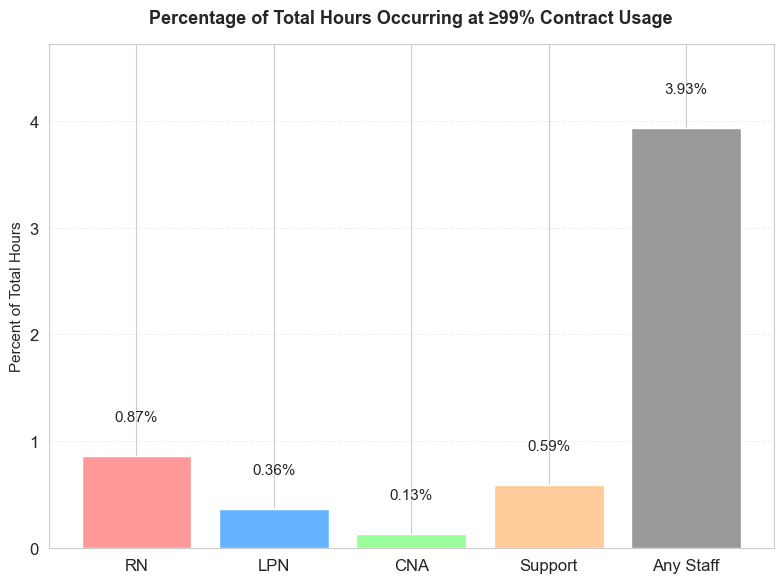

In [26]:
# -------------------------------------------------------
# Visualization: High Contract Usage by TOTAL HOURS
# -------------------------------------------------------
import matplotlib.pyplot as plt

# (1) Merge daily_ratios with support_hours so we have each day's nurse & support hours together
temp = daily_ratios.merge(
    support_hours,
    on=['provnum', 'workdate'],
    how='left',
    # so we don't overwrite columns, or rename as needed
    suffixes=('', '_support')
)

# (2) Calculate total hours for each staff type on each day
temp['rn_total_hrs'] = temp['hrs_rn_ctr'] + temp['hrs_rn_emp']
temp['lpn_total_hrs'] = temp['hrs_lpn_ctr'] + temp['hrs_lpn_emp']
temp['cna_total_hrs'] = temp['hrs_cna_ctr'] + temp['hrs_cna_emp']

# For Support staff, sum all *_ctr and *_emp columns from support_hours
support_ctr_cols = [col for col in support_hours.columns if col.endswith('_ctr')]
support_emp_cols = [col for col in support_hours.columns if col.endswith('_emp')]
temp['support_total_hrs'] = temp[support_ctr_cols].sum(axis=1) + temp[support_emp_cols].sum(axis=1)

# (3) For each staff type, figure out how many HOURS are in ≥99% contract situations
staff_types_map = {
    'RN':       ('rn_daily_ratio', 'rn_total_hrs'),
    'LPN':      ('lpn_daily_ratio', 'lpn_total_hrs'),
    'CNA':      ('cna_daily_ratio', 'cna_total_hrs'),
    'Support':  ('support_daily_ratio', 'support_total_hrs')
}

role_hours_high = {}
role_hours_total = {}

for role_label, (ratio_col, total_col) in staff_types_map.items():
    # Mask for ≥99% contract usage for that role
    mask_role = (temp[ratio_col] >= 0.99)
    
    # Sum that role’s total hours on days where that role hits ≥99% contract
    role_hours_high[role_label] = temp.loc[mask_role, total_col].sum()
    
    # Sum that role’s total hours across ALL days
    role_hours_total[role_label] = temp[total_col].sum()

# (4) "Any Staff" scenario:
#  - We have daily_ratios['high_contract_day'] set to True if ANY staff is ≥99%.
#  - We'll sum the total hours of *all staff* on those days, and compare vs. all staff hours overall.
temp['all_staff_hrs'] = (
    temp['rn_total_hrs'] +
    temp['lpn_total_hrs'] +
    temp['cna_total_hrs'] +
    temp['support_total_hrs']
)

mask_any = temp['high_contract_day']
any_high_hrs = temp.loc[mask_any, 'all_staff_hrs'].sum()
any_total_hrs = temp['all_staff_hrs'].sum()

# (5) Convert to percentages of total hours
role_percentages = {}
for role_label in staff_types_map.keys():
    pct = (role_hours_high[role_label] / role_hours_total[role_label]) * 100 if role_hours_total[role_label] else 0
    role_percentages[role_label] = pct

any_percentage = (any_high_hrs / any_total_hrs) * 100 if any_total_hrs else 0

# Prepare for bar chart
roles_order = list(role_percentages.keys()) + ['Any Staff']
values = list(role_percentages.values()) + [any_percentage]

# (6) Plot
fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(roles_order, values, color=['#FF9999','#66B3FF','#99FF99','#FFCC99','#999999'])

for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2, 
        h + 0.3, 
        f'{h:.2f}%', 
        ha='center', 
        va='bottom', 
        fontsize=11
    )

ax.set_title('Percentage of Total Hours Occurring at ≥99% Contract Usage',
             fontsize=13, pad=15, fontweight='bold')
ax.set_ylabel('Percent of Total Hours', fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_ylim(top=max(values)*1.2)

plt.tight_layout()
plt.show()


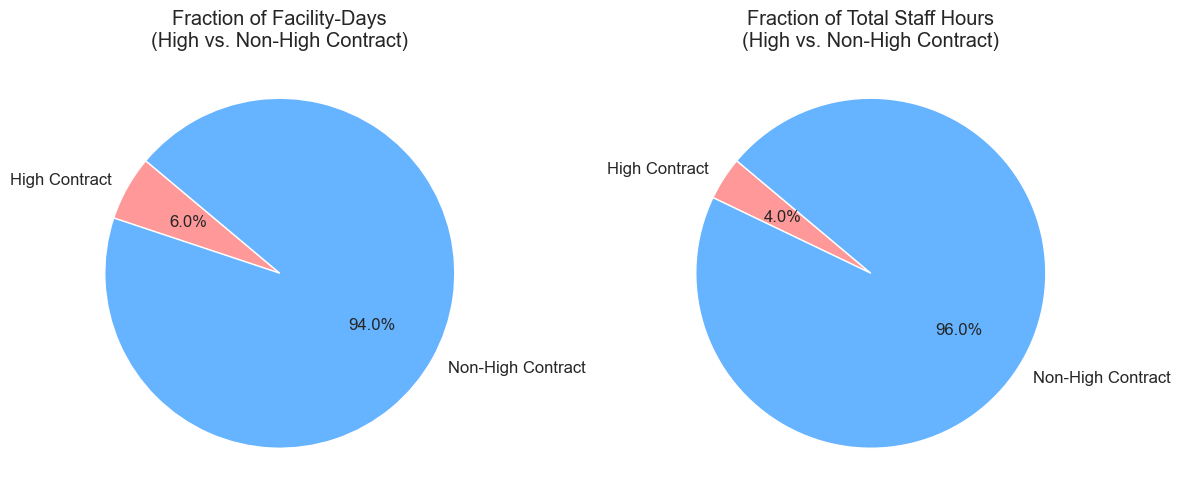

In [27]:
import matplotlib.pyplot as plt

# Suppose you've already computed these figures (from your QA checks):
#   - 6% of facility-days are high contract
#   - 4% of total hours occur on high-contract days
# (The rest, 94% or 96%, are non-high-contract.)
fraction_high_days = 6
fraction_high_hours = 4

fractions_days = [fraction_high_days, 100 - fraction_high_days]     # [High, Non-high]
fractions_hours = [fraction_high_hours, 100 - fraction_high_hours]  # [High, Non-high]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# -- Pie Chart: Fraction of Facility-Days
axes[0].pie(
    fractions_days,
    labels=["High Contract", "Non-High Contract"],
    autopct="%.1f%%",
    startangle=140,
    colors=["#FF9999", "#66B3FF"],
    wedgeprops={'edgecolor': 'white'}
)
axes[0].set_title("Fraction of Facility-Days\n(High vs. Non-High Contract)")

# -- Pie Chart: Fraction of Total Staff Hours
axes[1].pie(
    fractions_hours,
    labels=["High Contract", "Non-High Contract"],
    autopct="%.1f%%",
    startangle=140,
    colors=["#FF9999", "#66B3FF"],
    wedgeprops={'edgecolor': 'white'}
)
axes[1].set_title("Fraction of Total Staff Hours\n(High vs. Non-High Contract)")

plt.tight_layout()
plt.show()


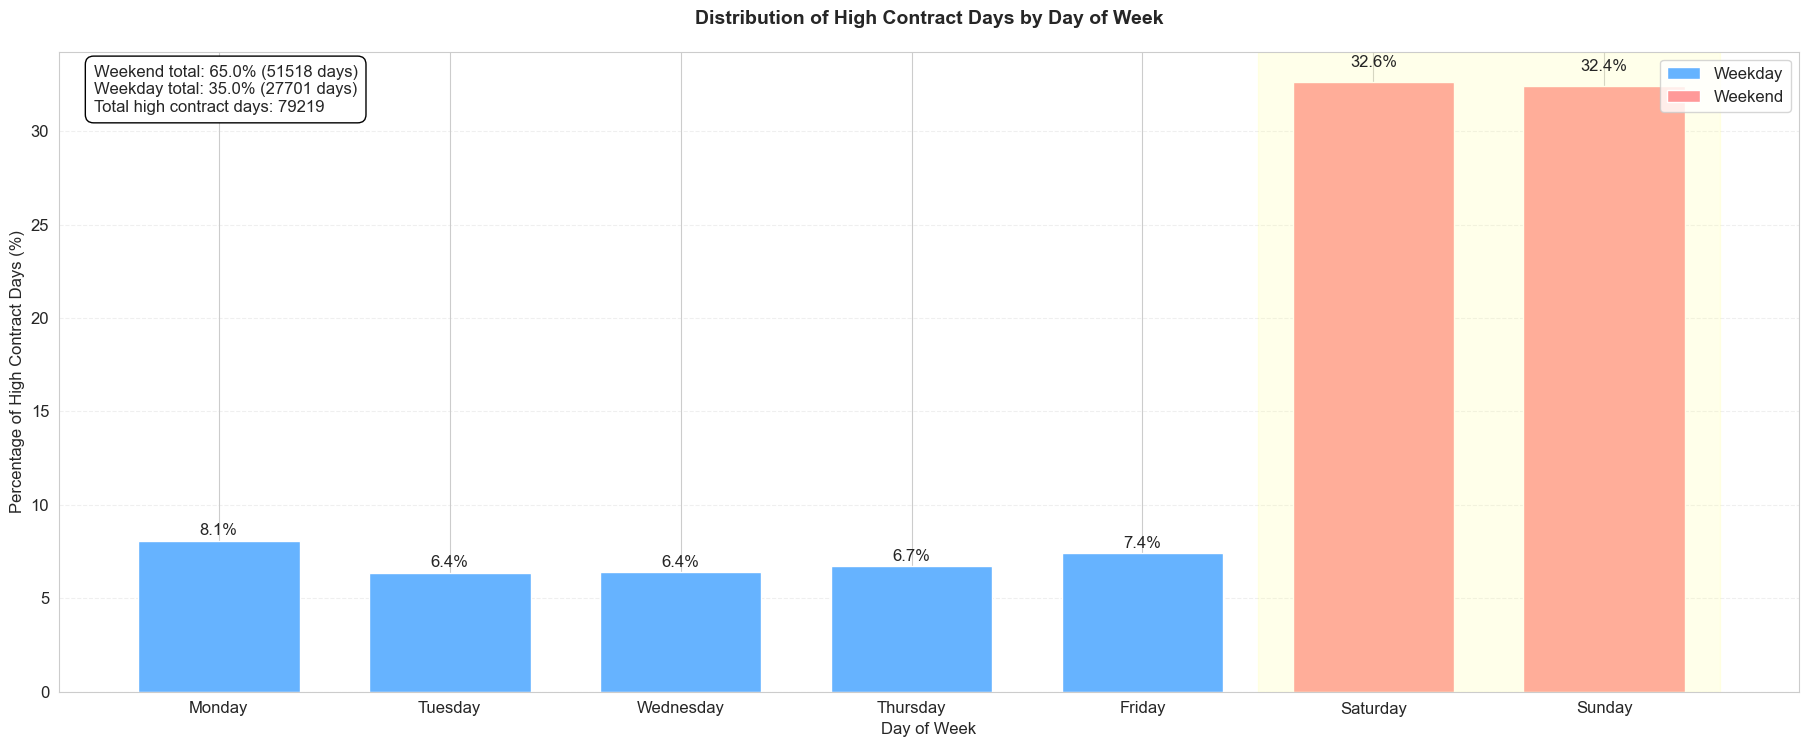

In [28]:
# -------------------------------------------------------
# 9. Identifying & Plotting High Contract Days by Day of Week
#    (Any Staff Type >= 99%)
# -------------------------------------------------------
# 1) Create a single flag for "high contract day" in daily_ratios
daily_ratios['high_contract_day'] = (
    (daily_ratios['rn_daily_ratio'] >= 0.99) |
    (daily_ratios['lpn_daily_ratio'] >= 0.99) |
    (daily_ratios['cna_daily_ratio'] >= 0.99) |
    (daily_ratios['support_daily_ratio'] >= 0.99)
)

# Group to see how often these occur by day_of_week
high_contract = daily_ratios[daily_ratios['high_contract_day']]
high_contract_by_day = high_contract.groupby('day_of_week').size()
percentage_by_day = (high_contract_by_day / high_contract_by_day.sum() * 100).round(2)

# Reindex to known weekday order
percentage_by_day = percentage_by_day.reindex(day_order)

fig, ax = plt.subplots(figsize=(20, 8))

weekday_color = '#66B3FF'
weekend_color = '#FF9999'

bars = ax.bar(
    range(len(day_order)),
    percentage_by_day.values,
    color=[weekday_color if d not in ['Saturday','Sunday'] else weekend_color for d in day_order],
    width=0.7
)

ax.set_xticks(range(len(day_order)))
ax.set_xticklabels(day_order, fontsize=12)

ax.set_title('Distribution of High Contract Days by Day of Week', 
             pad=20, fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage of High Contract Days (%)', fontsize=12)
ax.set_xlabel('Day of Week', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.3)

for idx, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        idx,
        height + (height * 0.02),
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=12
    )

legend_elements = [
    Patch(facecolor=weekday_color, label='Weekday'),
    Patch(facecolor=weekend_color, label='Weekend')
]
ax.legend(handles=legend_elements, fontsize=12, loc='upper right', frameon=True)

ax.axvspan(4.5, 6.5, color='#FFFF99', alpha=0.2)

weekend_pct = percentage_by_day[['Saturday', 'Sunday']].sum()
weekday_pct = percentage_by_day[['Monday','Tuesday','Wednesday','Thursday','Friday']].sum()
weekend_days = high_contract_by_day[['Saturday', 'Sunday']].sum()
weekday_days = high_contract_by_day[['Monday','Tuesday','Wednesday','Thursday','Friday']].sum()

summary_text = (
    f"Weekend total: {weekend_pct:.1f}% ({weekend_days:.0f} days)\n"
    f"Weekday total: {weekday_pct:.1f}% ({weekday_days:.0f} days)\n"
    f"Total high contract days: {high_contract_by_day.sum():.0f}"
)

plt.text(
    0.02, 0.98,
    summary_text,
    transform=ax.transAxes,
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.5'
    ),
    fontsize=12,
    verticalalignment='top'
)

plt.subplots_adjust(right=0.95, left=0.08, bottom=0.12, top=0.92)
plt.show()




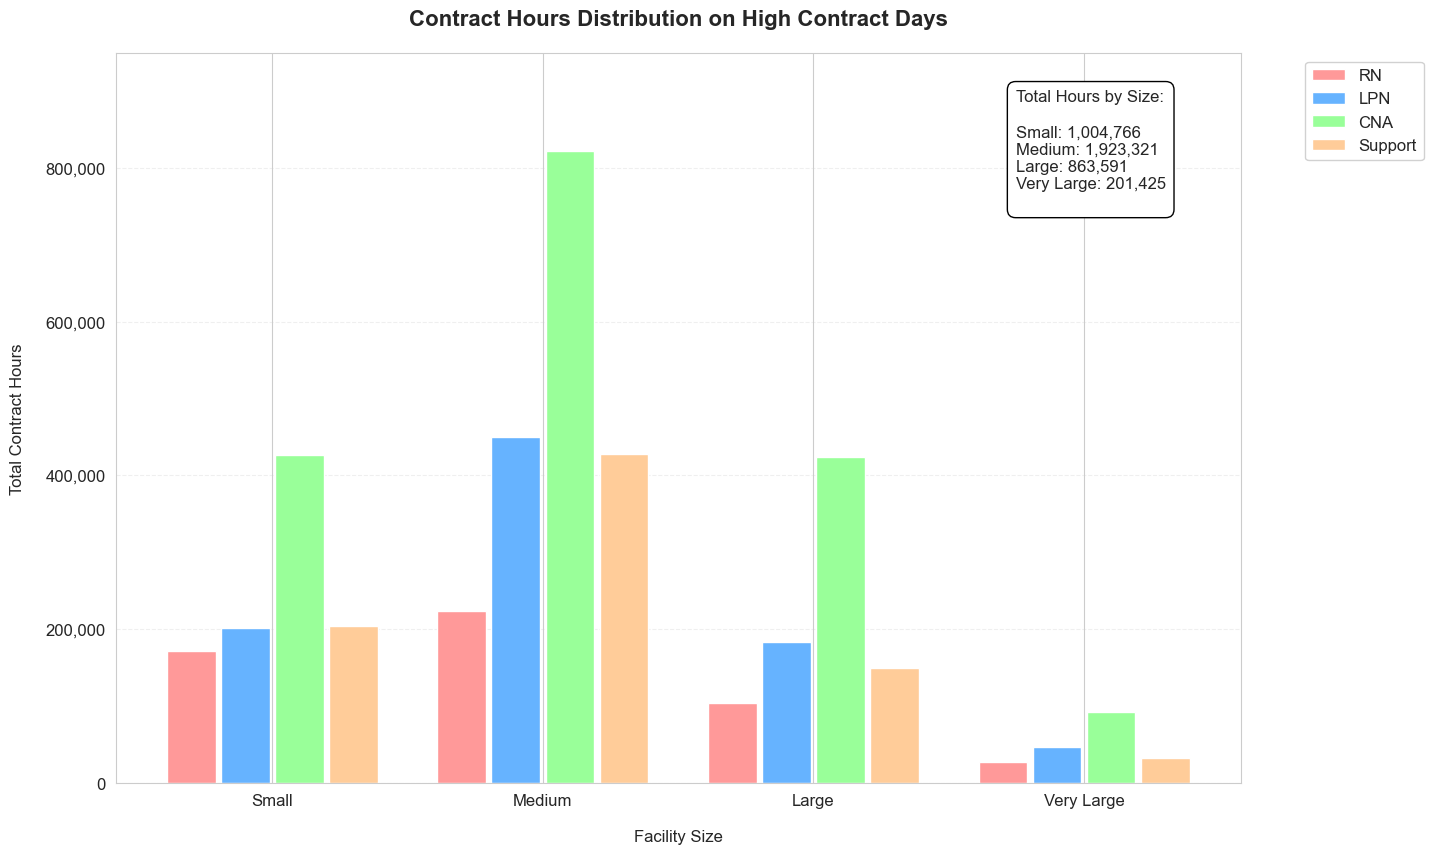

In [29]:
# -------------------------------------------------------
# 10. Contract Hours Distribution on High Contract Days
# -------------------------------------------------------
# We already have daily_ratios['high_contract_day'], so let's find those days
high_contract_days = daily_ratios[daily_ratios['high_contract_day']][['provnum','workdate']].drop_duplicates()

# Merge with nurse data to see actual contract hours for RNs, LPNs, CNAs
nurse_high_contract = pd.merge(
    df_pbj_nurse, 
    high_contract_days, 
    on=['provnum','workdate'],
    how='inner'
)

# Merge with support data for the same set of high-contract days
support_high_contract = pd.merge(
    df_pbj_non_nurse, 
    high_contract_days,
    on=['provnum','workdate'],
    how='inner'
)

# Attach facility size to the nurse data (we can do the same for support if needed)
nurse_high_contract['size_category'] = nurse_high_contract['provnum'].map(size_mapping)

# Summarize contract hours by staff type *within* those high-contract days
data = {
    'Size': SIZE_ORDER,
    'RN': [],
    'LPN': [],
    'CNA': [],
    'Support': []
}

for sz in SIZE_ORDER:
    # Subset to that size
    size_nurse_data = nurse_high_contract[nurse_high_contract['size_category'] == sz]
    # Unique facs & dates that are "high contract" in that size category
    exclusive_facilities = size_nurse_data['provnum'].unique()
    exclusive_dates = size_nurse_data['workdate'].unique()

    # Filter support data to the same facilities/dates
    size_support_data = support_high_contract[
        (support_high_contract['provnum'].isin(exclusive_facilities)) &
        (support_high_contract['workdate'].isin(exclusive_dates))
    ]

    # Sum contract hours
    data['RN'].append(size_nurse_data['hrs_rn_ctr'].sum())
    data['LPN'].append(size_nurse_data['hrs_lpn_ctr'].sum())
    data['CNA'].append(size_nurse_data['hrs_cna_ctr'].sum())

    # For support staff, sum all *_ctr columns
    support_ctr_cols = [c for c in size_support_data.columns if c.endswith('_ctr')]
    data['Support'].append(size_support_data[support_ctr_cols].sum().sum())

# Convert into a DataFrame
df_hours = pd.DataFrame(data)

# Count how many high-contract days for each size category
# (we can group by 'size_category' in nurse_high_contract, for instance)
days_by_size = nurse_high_contract.groupby('size_category')['workdate'].nunique()

# Plot
fig, ax = plt.subplots(figsize=(15, 10))

colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']
staff_types = ['RN', 'LPN', 'CNA', 'Support']

n_staff = len(staff_types)
total_width = 0.8
bar_width = total_width / n_staff
positions = np.arange(len(SIZE_ORDER))

for i, (staff, color) in enumerate(zip(staff_types, colors)):
    x = positions + (i - n_staff/2 + 0.5) * bar_width
    values = df_hours[staff].values
    bars = ax.bar(x, values, bar_width * 0.9, label=staff, color=color)


ax.set_title('Contract Hours Distribution on High Contract Days',
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Facility Size', fontsize=12, labelpad=15)
ax.set_ylabel('Total Contract Hours', fontsize=12, labelpad=15)

ax.set_xticks(positions)
ax.set_xticklabels(SIZE_ORDER)

ax.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)
ax.set_axisbelow(True)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

# Summary text: total contract hours by size
summary_text = "Total Hours by Size:\n\n"
for sz in SIZE_ORDER:
    total_hours = df_hours[df_hours['Size'] == sz][staff_types].sum().sum()
    summary_text += f"{sz}: {int(total_hours):,}\n"

plt.text(
    0.8, 0.95,
    summary_text,
    transform=ax.transAxes,
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.5'
    ),
    fontsize=12,
    verticalalignment='top'
)

plt.subplots_adjust(right=0.85, bottom=0.15, left=0.1)
plt.show()
